In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pdb
import os
import math
import fnmatch
from moviepy.editor import VideoFileClip
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
import random
import time
from scipy.ndimage.measurements import label
from numba import vectorize, cuda, uint8, float64
from collections import deque
from sklearn.preprocessing import scale
%matplotlib inline

FNAMES = glob.glob('./test_images/test*.jpg')
CARF = [os.path.join(dirpath, f) for dirpath, dirnames, files in os.walk('./data/vehicles/') 
        for f in fnmatch.filter(files, '*.png')]
NONCARF = [os.path.join(dirpath, f) for dirpath, dirnames, files in os.walk('./data/non-vehicles/') 
           for f in fnmatch.filter(files, '*.png')]
random.shuffle(CARF)
random.shuffle(NONCARF)

In [2]:
def getImages(fnames):
    """
    
    This function imports images from a list of files
    
    Args:
          (1) fnames (str): An array containing the path of the images
    Return:
          (1) images (uint8): An array of all images specified in fnames
          (2) Image Title (str): An array with the names of the image files
    
    """
    images = []
    titles = []
    for file in fnames:
        titles.append(file.split('\\')[-1])
        images.append(mpimg.imread(file))
    return images, titles

def display(images, figsize=(20,20), k=2, titles=None, axis='off', cmap='hot', fontsize=20):
    """
    
    This function takes a array of images as an input and displays the images in a window
    
    Args:
            (1) images (uint8): An array of image paths to display
            (2) m, n (int): Dimensions of displays window
            (3) k (int): Number of images per row to display
            (4) titles (str): An array with the plot titles
            (5) axis (str): Plot axis parameter
            (6) cmap (str): Plot colour map
    Returns:   
            (1) A window displaying all images
    
    """
    n_imgs = len(images)
    plt.figure(figsize = figsize)
    for i,img in enumerate(images):
        plt.subplot(math.ceil(n_imgs/k), k, i+1)
        plt.imshow(img, cmap=cmap)
        if(titles == None):
            plt.title(i, fontsize=fontsize)
        else:
            plt.title(titles[i], fontsize=fontsize)
        plt.axis(axis)
    plt.show()

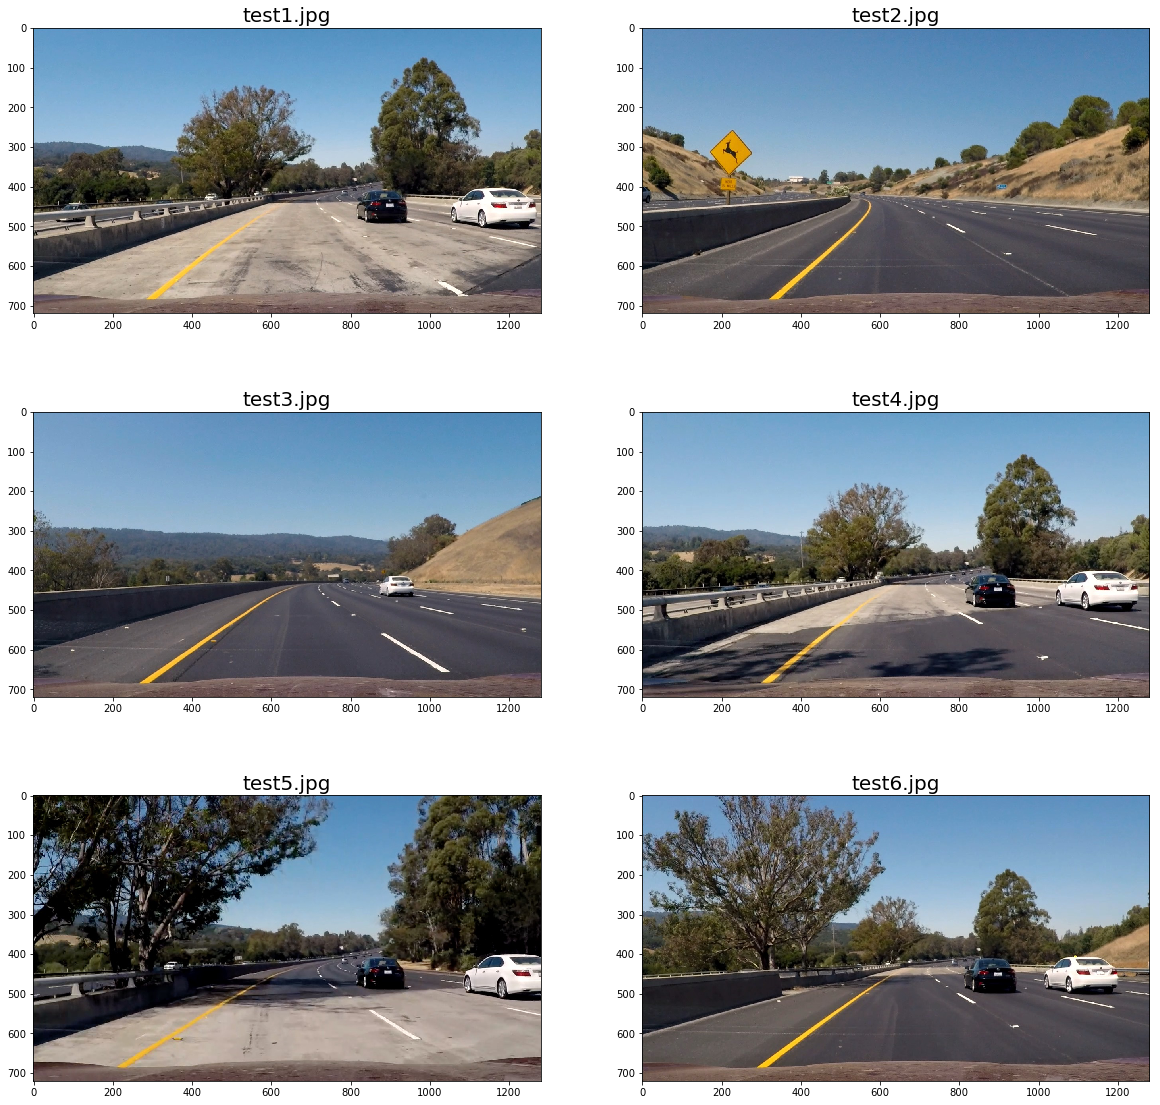

In [3]:
def showTestImages():
    images, titles = getImages(FNAMES)
    display(images, titles=titles, axis='on')

if __name__=="__main__":
    showTestImages()

In [4]:
def convert_color(img, conv='BGR'):
    color = 'cv2.COLOR_RGB2' + conv
    if (conv == 'RGB'):
        color = '1'
    cnvt_img = cv2.cvtColor(img, eval(color))
    return cnvt_img

def get_hog_features(img, orient=9, pix_per_cell=6, cell_per_block=2, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def bin_spatial_show(img, size=(64, 64)):
    color1 = cv2.resize(img[:,:,0], size)
    color2 = cv2.resize(img[:,:,1], size)
    color3 = cv2.resize(img[:,:,2], size)
    return color1, color2, color3
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, 
                     cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        
        feature_image = convert_color(image, conv=color_space)      
        
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, 
                                                         cell_per_block, vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, 
                                                cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

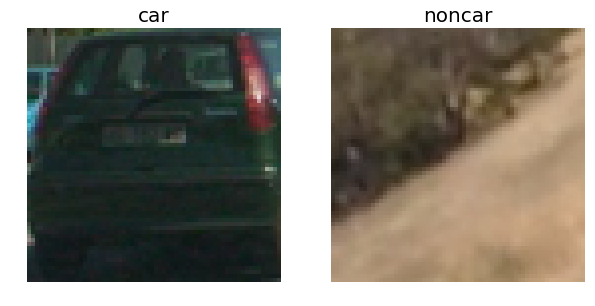

In [9]:
def showCarNonCar():
    images = []
    #for i in range(2):
    images.append(mpimg.imread(CARF[4]))
    images.append(mpimg.imread(NONCARF[0]))
    display(images, k=2, figsize=(10,10), titles=['car', 'noncar']) #, 'car', 'noncar'])

if __name__=="__main__":
    showCarNonCar()

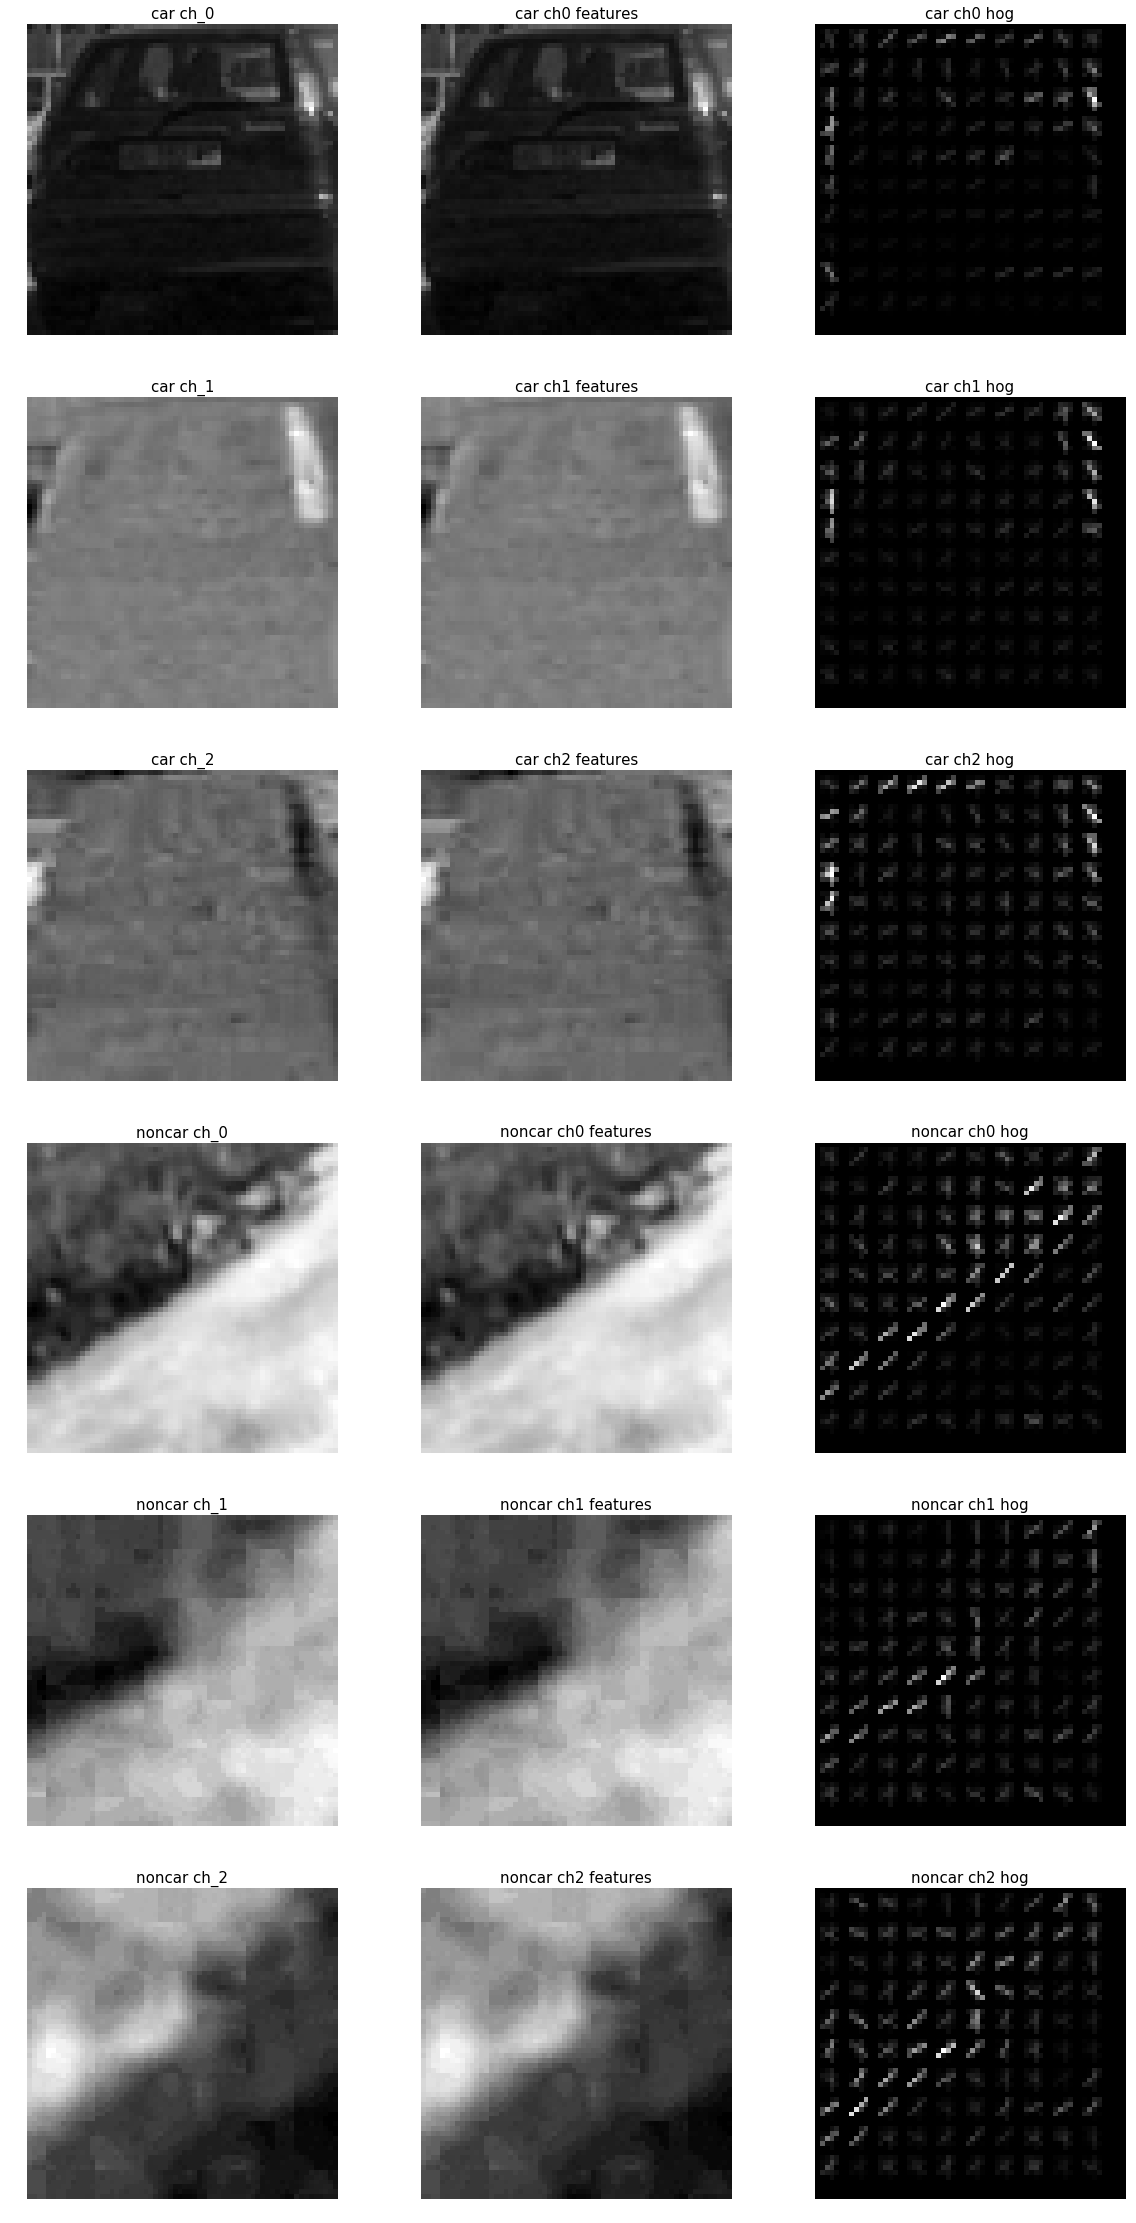

In [11]:
def showHogFeatures():
    car1 = mpimg.imread(CARF[4])
    noncar1 = mpimg.imread(NONCARF[0])
    
    car = convert_color(car1, 'YCrCb')
    noncar = convert_color(noncar1, 'YCrCb')
    
    carch0_f, carch1_f, carch2_f = bin_spatial_show(car)
    noncarch0_f, noncarch1_f, noncarch2_f = bin_spatial_show(noncar)
    
    carch0 = car[:,:,0]
    carch0_hf, carch0_hog = get_hog_features(carch0, vis=True, feature_vec=False)
    carch1 = car[:,:,1]
    carch1_hf, carch1_hog = get_hog_features(carch1, vis=True, feature_vec=False)
    carch2 = car[:,:,2]
    carch2_hf, carch2_hog = get_hog_features(carch2, vis=True, feature_vec=False)
    
    noncarch0 = noncar[:,:,0]
    noncarch0_hf, noncarch0_hog = get_hog_features(noncarch0, vis=True, feature_vec=False)
    noncarch1 = noncar[:,:,1]
    noncarch1_hf, noncarch1_hog = get_hog_features(noncarch1, vis=True, feature_vec=False)
    noncarch2 = noncar[:,:,2]
    noncarch2_hf, noncarch2_hog = get_hog_features(noncarch2, vis=True, feature_vec=False)
    
    images = [carch0, carch0_f, carch0_hog, carch1, carch1_f, carch1_hog, carch2, carch2_f, carch2_hog,
              noncarch0, noncarch0_f, noncarch0_hog, noncarch1, noncarch1_f, noncarch1_hog, noncarch2, 
              noncarch2_f, noncarch2_hog]
    titles = ['car ch_0', 'car ch0 features', 'car ch0 hog', 'car ch_1', 'car ch1 features', 'car ch1 hog',
             'car ch_2', 'car ch2 features', 'car ch2 hog', 'noncar ch_0', 'noncar ch0 features', 'noncar ch0 hog',
             'noncar ch_1', 'noncar ch1 features', 'noncar ch1 hog', 
             'noncar ch_2', 'noncar ch2 features', 'noncar ch2 hog']
    display(images, titles=titles, k=3, figsize=(20,40), cmap='gray', fontsize=15)

if __name__=="__main__":
    showHogFeatures()

In [12]:
# Global variables

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 6 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (64, 64) # Spatial binning dimensions
hist_bins = 32   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
ystart = 400
ystop = 656
xstart = 0
xstop = 1280
scale = 1.2

centroid = []

In [13]:
def train():
    t1 = time.time()
    random.shuffle(CARF)
    random.shuffle(NONCARF)
    
    cars = CARF
    notcars = NONCARF
    
    car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, 
                                    hog_feat=hog_feat)
    
    notcar_features = extract_features(notcars, color_space=color_space, spatial_size=spatial_size, 
                                       hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                       spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    t3 = time.time()
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
    
    print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC
    t4 = time.time()
    print(t4-t3, t3-t1)
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    return svc, X_scaler
if __name__=="__main__":
    svc, X_scaler = train()


Using: 9 orientations 6 pixels per cell and 2 cells per block
Feature vector length: 21132
10.32112455368042 86.18503284454346
36.85 Seconds to train SVC...
Test Accuracy of SVC =  0.989


In [14]:
def addHeat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        centroid.append(((bbox[0][0] + bbox[1][0]) // 2, (bbox[0][1] + bbox[1][1]) // 2))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img

In [15]:
def findCars(img, ystart=ystart, ystop=ystop, scale=scale, svc=svc, X_scaler=X_scaler, orient=orient, hog_channel=hog_channel,
             pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    bboxes = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    # Compute individual channel HOG features for the entire image
    if hog_channel == 'ALL':
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    else:
        hog_feat = get_hog_features(ctrans_tosearch[:,:,hog_channel], orient, pix_per_cell, 
                                        cell_per_block, vis=False, feature_vec=False)
        
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            if hog_channel == 'ALL':
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
           
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    return draw_img, bboxes

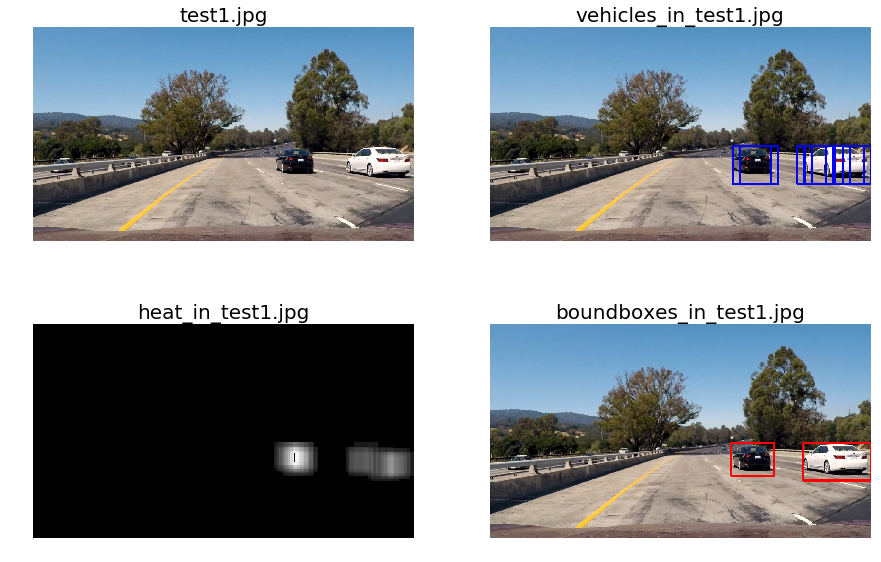

In [19]:
def vehiclesTestImages():
    test_imgs, imgtitles = getImages(FNAMES[:1])
    cartitles = ['vehicles_in_' + img for img in imgtitles]
    heattitles = ['heat_in_' + img for img in imgtitles]
    boundtitles = ['boundboxes_in_' + img for img in imgtitles]
    car_imgs = []
    heat_imgs = []
    bound_imgs = []
    for img in test_imgs:
        heatimg = np.zeros_like(img)
        for scale in [1.0, 1.2, 1.3, 1.4, 1.5, 2.0]:
            car_img, bbox_list = findCars(img, scale=scale)
            heat_img = addHeat(heatimg, bbox_list)
        car_imgs.append(car_img)
        heat_img = apply_threshold(heat_img,4)
        heat_img = np.array(heat_img, np.float64)
        scaled_heat = (heat_img - heat_img.max()) / (heat_img.max() - heat_img.min())
        heat_imgs.append(scaled_heat)
        labels = label(heat_img)
        bound_img = draw_labeled_bboxes(np.copy(img), labels)
        bound_imgs.append(bound_img)
        
    images=[]
    titles = []
    for i in range(len(car_imgs)):
        images.append(test_imgs[i])
        images.append(car_imgs[i])
        images.append(heat_imgs[i])
        images.append(bound_imgs[i])
        titles.append(imgtitles[i])
        titles.append(cartitles[i])
        titles.append(heattitles[i])
        titles.append(boundtitles[i])
    display(images, k=2, figsize=(15,10), titles=titles)

if __name__=="__main__":
    vehiclesTestImages()

In [20]:
heatmap = []
def processVideo(img):
    heatimg = np.zeros_like(img)
    for scale in [1.0, 1.2, 1.3, 1.4, 1.5, 2.0]:
        car_img, bbox_list = findCars(img, scale=scale)
        heat_img = addHeat(heatimg, bbox_list)
    heatmap.append(heat_img)
    combined_heat = np.sum(heatmap[-5:], axis=0)
    heat_img = apply_threshold(combined_heat,4)
    labels = label(heat_img)
    bound_img = draw_labeled_bboxes(np.copy(img), labels)
    cv2.putText(bound_img, 'Number of Vehicles: {}'.format(len(labels)), (100,80), fontFace = 16, fontScale = 2, 
                color=(255,255,255), thickness = 3)
    
    return bound_img

In [21]:
def videoOutput():
    """
    
    This function loads a test video, performs the processVideo() function on each video frame and writes the
    output video
    
    Args: None
    Return: None
    
    """
    video_output = 'project_video_output.mp4'
    clip1 = VideoFileClip("project_video.mp4")
    white_clip = clip1.fl_image(processVideo) # Perform the process image function
    white_clip.write_videofile(video_output, audio=False) # Write the output video
    
if __name__=="__main__":
    videoOutput()

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [02:41<00:04,  4.26s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 



In [22]:
# Display the processed image
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('test_video_output.mp4'))